In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='3'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

TARGET_METRIC='max_temp'
SAMPLE_SIZE=10000

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    ConvertProfileListToCsv,
    CreateProfileSubset,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2,
    PlotHistograms,
    PlotComparativeHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v2', f'profiles-v2-jsons')
ORIGINAL_PROFILE_LIST_JSON = os.path.join(DATASET_DIR, f'profiles-v2', f'profile_list_v2.json')
LABEL = f'profiles_v2_experiment_{EXPERIMENT_NUM}'
BINNED_PROFILE_LIST = os.path.join(DATASET_DIR, 'profiles-v2', 'profile_list_v2_binned.json')

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v2_experiment_3_20250329_2102


In [3]:
# * * * * * * * * * * * * * * * *
# Create Subset by Metric
# * * * * * * * * * * * * * * * *
SUBSET_PROFILE_LIST = os.path.join(model_dir, f'profile_list_v2_{TARGET_METRIC}_{SAMPLE_SIZE}.json')
CreateProfileSubset(BINNED_PROFILE_LIST, SUBSET_PROFILE_LIST, TARGET_METRIC, SAMPLE_SIZE)

In [4]:
# * * * * * * * * * * * * * * * *
# Load Profile List
# * * * * * * * * * * * * * * * *
profile_list = LoadProfileList(SUBSET_PROFILE_LIST)

In [5]:
# * * * * * * * * * * * * * * * *
# Convert to CSV
# * * * * * * * * * * * * * * * *
csv_path = ConvertProfileListToCsv(PROFILES_DIR, profile_list, model_dir)

Processing Profiles: 100%|██████████| 245999/245999 [01:20<00:00, 3063.75it/s]

Saved 245999 profiles to /workspace/outputs/profiles_v2_experiment_3_20250329_2102/20250329-dataset.csv


In [6]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV2(csv_path, DEVICE)

Loading Profiles: 245999it [00:14, 17268.67it/s]


Saved figure to /workspace/outputs/profiles_v2_experiment_3_20250329_2102/density_plot.png


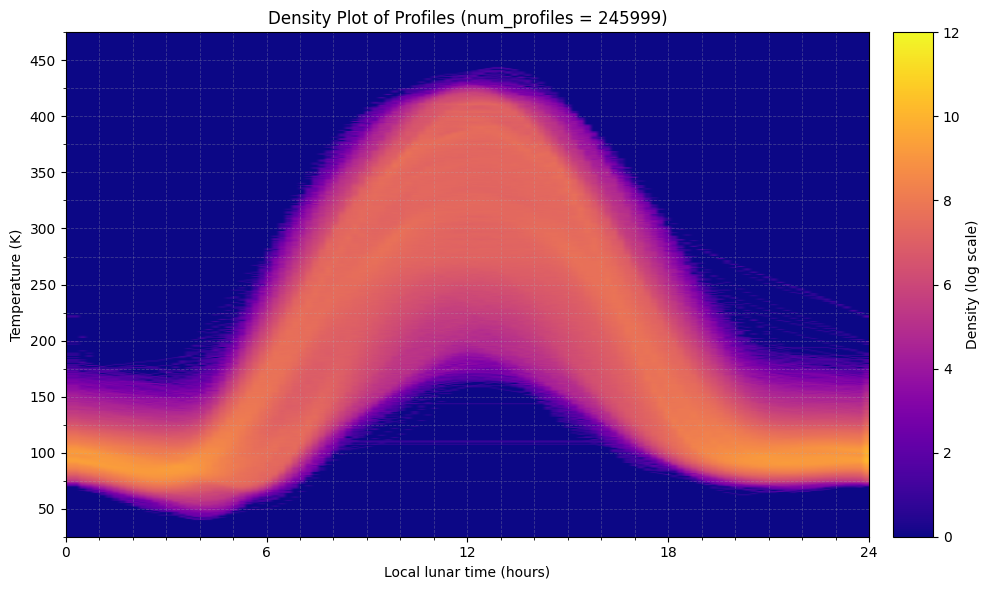

In [7]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [8]:
# * * * * * * * * * * * * * * * *
# Load Original Profile List
# * * * * * * * * * * * * * * * *
original_profile_list = LoadProfileList(ORIGINAL_PROFILE_LIST_JSON)

Saved figure to /workspace/outputs/profiles_v2_experiment_3_20250329_2102/histogram_max_temp.png


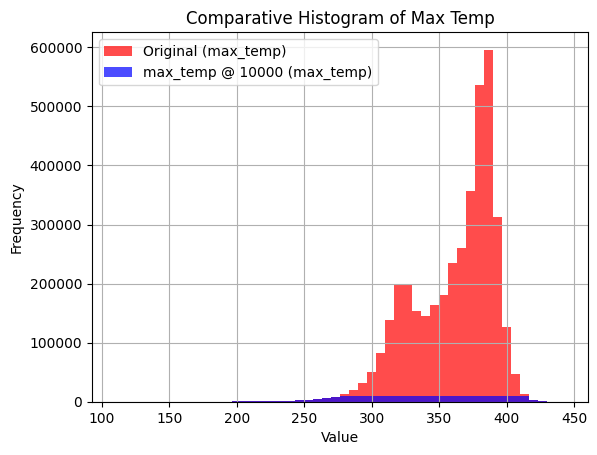

Saved figure to /workspace/outputs/profiles_v2_experiment_3_20250329_2102/histogram_min_temp.png


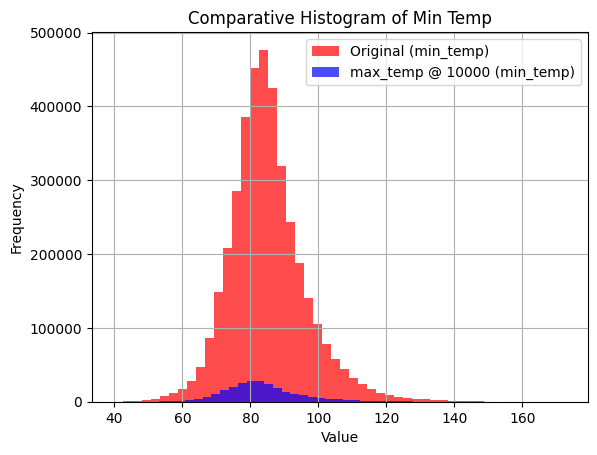

Saved figure to /workspace/outputs/profiles_v2_experiment_3_20250329_2102/histogram_mean_temp.png


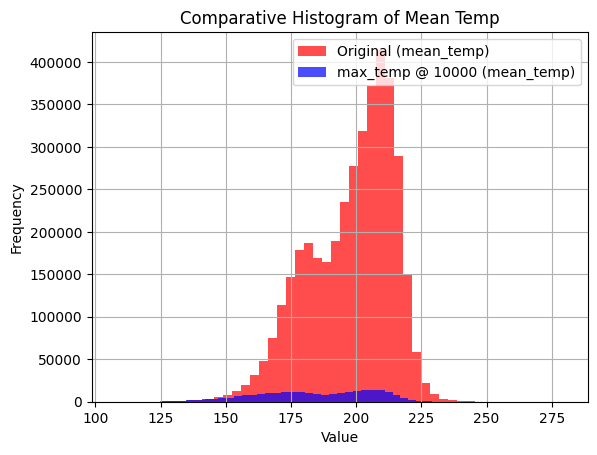

Saved figure to /workspace/outputs/profiles_v2_experiment_3_20250329_2102/histogram_std_temp.png


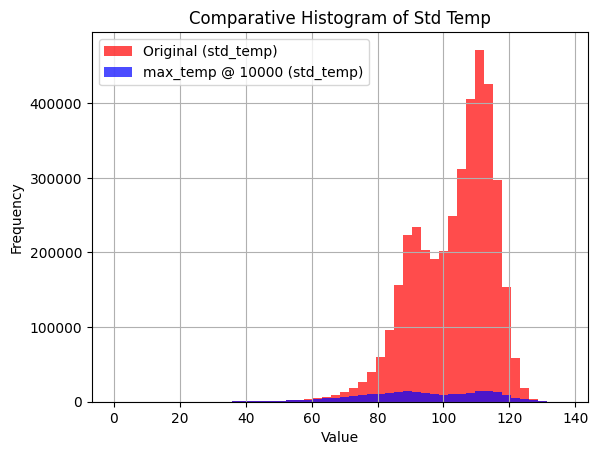

In [9]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
statistics_original = CollectStatisticsFromProfilesV2(PROFILES_DIR, original_profile_list)
statistics_subset = CollectStatisticsFromProfilesV2(PROFILES_DIR, profile_list)
PlotComparativeHistograms(statistics_original, statistics_subset, labels=("Original", f"{TARGET_METRIC} @ {SAMPLE_SIZE}"), output_dir=model_dir)

In [10]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 184.6093
STD: 97.4582
Min Temp: 40.2370
Max Temp: 443.4440
Datasets:
Training Data: 172199
Validation Data: 49199
Test Data: 24601


In [11]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

In [12]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

[Training] Epoch 1/100: 100%|██████████| 861/861 [00:28<00:00, 30.33it/s, best_loss=0.7997]


[Training] Epoch 1/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0017, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 246/246 [00:02<00:00, 88.36it/s] 


[Validation] Epoch 1/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_3_20250329_2102'


[Training] Epoch 2/100: 100%|██████████| 861/861 [00:28<00:00, 30.13it/s, best_loss=0.8478]


[Training] Epoch 2/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 246/246 [00:02<00:00, 104.69it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 3/100: 100%|██████████| 861/861 [00:29<00:00, 29.52it/s, best_loss=0.8392]


[Training] Epoch 3/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 246/246 [00:02<00:00, 102.28it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 4/100: 100%|██████████| 861/861 [00:28<00:00, 29.80it/s, best_loss=0.8259]


[Training] Epoch 4/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 246/246 [00:02<00:00, 103.70it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 5/100: 100%|██████████| 861/861 [00:29<00:00, 29.55it/s, best_loss=0.8028]


[Training] Epoch 5/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 246/246 [00:02<00:00, 100.25it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 6/100: 100%|██████████| 861/861 [00:29<00:00, 29.62it/s, best_loss=0.8383]


[Training] Epoch 6/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 246/246 [00:02<00:00, 105.79it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 7/100: 100%|██████████| 861/861 [00:28<00:00, 30.06it/s, best_loss=0.8354]


[Training] Epoch 7/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 246/246 [00:02<00:00, 93.24it/s] 


[Validation] Epoch 7/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 8/100: 100%|██████████| 861/861 [00:28<00:00, 30.32it/s, best_loss=0.8198]


[Training] Epoch 8/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 246/246 [00:02<00:00, 102.40it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 9/100: 100%|██████████| 861/861 [00:29<00:00, 29.63it/s, best_loss=0.8134]


[Training] Epoch 9/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 246/246 [00:02<00:00, 105.95it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 10/100: 100%|██████████| 861/861 [00:28<00:00, 29.80it/s, best_loss=0.7974]


[Training] Epoch 10/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 246/246 [00:02<00:00, 102.50it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 11/100: 100%|██████████| 861/861 [00:29<00:00, 29.68it/s, best_loss=0.8348]


[Training] Epoch 11/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 246/246 [00:02<00:00, 100.31it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 12/100: 100%|██████████| 861/861 [00:28<00:00, 29.76it/s, best_loss=0.8411]


[Training] Epoch 12/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 246/246 [00:02<00:00, 105.85it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 13/100: 100%|██████████| 861/861 [00:29<00:00, 29.57it/s, best_loss=0.8423]


[Training] Epoch 13/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 246/246 [00:02<00:00, 101.43it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 14/100: 100%|██████████| 861/861 [00:28<00:00, 30.14it/s, best_loss=0.8236]


[Training] Epoch 14/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 246/246 [00:02<00:00, 86.66it/s] 


[Validation] Epoch 14/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 15/100: 100%|██████████| 861/861 [00:28<00:00, 29.96it/s, best_loss=0.8224]


[Training] Epoch 15/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 246/246 [00:02<00:00, 109.93it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 16/100: 100%|██████████| 861/861 [00:29<00:00, 29.52it/s, best_loss=0.8618]


[Training] Epoch 16/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 246/246 [00:02<00:00, 102.81it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 17/100: 100%|██████████| 861/861 [00:28<00:00, 30.28it/s, best_loss=0.8212]


[Training] Epoch 17/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 246/246 [00:02<00:00, 107.51it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 18/100: 100%|██████████| 861/861 [00:27<00:00, 30.96it/s, best_loss=0.7988]


[Training] Epoch 18/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 246/246 [00:02<00:00, 108.91it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 19/100: 100%|██████████| 861/861 [00:27<00:00, 31.16it/s, best_loss=0.8563]


[Training] Epoch 19/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 246/246 [00:02<00:00, 109.77it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 20/100: 100%|██████████| 861/861 [00:27<00:00, 31.64it/s, best_loss=0.8234]


[Training] Epoch 20/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 246/246 [00:02<00:00, 98.68it/s] 


[Validation] Epoch 20/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 21/100: 100%|██████████| 861/861 [00:27<00:00, 31.88it/s, best_loss=0.8524]


[Training] Epoch 21/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 246/246 [00:02<00:00, 113.78it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 22/100: 100%|██████████| 861/861 [00:27<00:00, 30.90it/s, best_loss=0.8019]


[Training] Epoch 22/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 246/246 [00:02<00:00, 110.02it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 23/100: 100%|██████████| 861/861 [00:27<00:00, 31.16it/s, best_loss=0.7909]


[Training] Epoch 23/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 246/246 [00:02<00:00, 107.52it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 24/100: 100%|██████████| 861/861 [00:27<00:00, 31.27it/s, best_loss=0.7889]


[Training] Epoch 24/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 246/246 [00:02<00:00, 111.16it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 25/100: 100%|██████████| 861/861 [00:27<00:00, 31.62it/s, best_loss=0.8277]


[Training] Epoch 25/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 246/246 [00:02<00:00, 109.44it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 26/100: 100%|██████████| 861/861 [00:27<00:00, 30.89it/s, best_loss=0.8432]


[Training] Epoch 26/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 246/246 [00:02<00:00, 107.30it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 27/100: 100%|██████████| 861/861 [00:27<00:00, 31.39it/s, best_loss=0.8360]


[Training] Epoch 27/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 246/246 [00:02<00:00, 92.18it/s] 


[Validation] Epoch 27/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 28/100: 100%|██████████| 861/861 [00:27<00:00, 31.58it/s, best_loss=0.8158]


[Training] Epoch 28/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 246/246 [00:02<00:00, 106.44it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 29/100: 100%|██████████| 861/861 [00:27<00:00, 31.06it/s, best_loss=0.8336]


[Training] Epoch 29/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 246/246 [00:02<00:00, 108.34it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 30/100: 100%|██████████| 861/861 [00:27<00:00, 30.95it/s, best_loss=0.8465]


[Training] Epoch 30/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 246/246 [00:02<00:00, 108.23it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 31/100: 100%|██████████| 861/861 [00:27<00:00, 31.46it/s, best_loss=0.8419]


[Training] Epoch 31/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 246/246 [00:02<00:00, 110.33it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 32/100: 100%|██████████| 861/861 [00:27<00:00, 31.10it/s, best_loss=0.8200]


[Training] Epoch 32/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 246/246 [00:02<00:00, 108.68it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 33/100: 100%|██████████| 861/861 [00:27<00:00, 31.08it/s, best_loss=0.8281]


[Training] Epoch 33/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 246/246 [00:02<00:00, 89.09it/s] 


[Validation] Epoch 33/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 34/100: 100%|██████████| 861/861 [00:27<00:00, 31.40it/s, best_loss=0.8255]


[Training] Epoch 34/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 246/246 [00:02<00:00, 107.99it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 35/100: 100%|██████████| 861/861 [00:27<00:00, 30.97it/s, best_loss=0.8382]


[Training] Epoch 35/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 246/246 [00:02<00:00, 109.84it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 36/100: 100%|██████████| 861/861 [00:27<00:00, 31.00it/s, best_loss=0.8287]


[Training] Epoch 36/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 246/246 [00:02<00:00, 105.49it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 37/100: 100%|██████████| 861/861 [00:27<00:00, 31.13it/s, best_loss=0.8172]


[Training] Epoch 37/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 246/246 [00:02<00:00, 106.31it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 38/100: 100%|██████████| 861/861 [00:27<00:00, 30.93it/s, best_loss=0.8394]


[Training] Epoch 38/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 246/246 [00:02<00:00, 109.86it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 39/100: 100%|██████████| 861/861 [00:27<00:00, 31.66it/s, best_loss=0.8393]


[Training] Epoch 39/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 246/246 [00:02<00:00, 95.32it/s] 


[Validation] Epoch 39/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 40/100: 100%|██████████| 861/861 [00:27<00:00, 31.43it/s, best_loss=0.8484]


[Training] Epoch 40/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 246/246 [00:02<00:00, 93.24it/s] 


[Validation] Epoch 40/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 41/100: 100%|██████████| 861/861 [00:27<00:00, 31.54it/s, best_loss=0.8428]


[Training] Epoch 41/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 246/246 [00:02<00:00, 109.73it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 42/100: 100%|██████████| 861/861 [00:27<00:00, 31.19it/s, best_loss=0.8230]


[Training] Epoch 42/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 246/246 [00:02<00:00, 109.69it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 43/100: 100%|██████████| 861/861 [00:27<00:00, 31.45it/s, best_loss=0.8189]


[Training] Epoch 43/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 246/246 [00:02<00:00, 111.37it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 44/100: 100%|██████████| 861/861 [00:27<00:00, 30.98it/s, best_loss=0.8421]


[Training] Epoch 44/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 246/246 [00:02<00:00, 106.42it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 45/100: 100%|██████████| 861/861 [00:27<00:00, 31.56it/s, best_loss=0.8094]


[Training] Epoch 45/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 246/246 [00:02<00:00, 104.26it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 46/100: 100%|██████████| 861/861 [00:27<00:00, 31.21it/s, best_loss=0.8302]


[Training] Epoch 46/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 246/246 [00:02<00:00, 95.59it/s] 


[Validation] Epoch 46/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 47/100: 100%|██████████| 861/861 [00:27<00:00, 31.87it/s, best_loss=0.8269]


[Training] Epoch 47/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 246/246 [00:02<00:00, 106.81it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 48/100: 100%|██████████| 861/861 [00:27<00:00, 31.01it/s, best_loss=0.8346]


[Training] Epoch 48/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 246/246 [00:02<00:00, 107.09it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 49/100: 100%|██████████| 861/861 [00:27<00:00, 31.22it/s, best_loss=0.7925]


[Training] Epoch 49/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 246/246 [00:02<00:00, 104.65it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 50/100: 100%|██████████| 861/861 [00:27<00:00, 31.13it/s, best_loss=0.8412]


[Training] Epoch 50/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 246/246 [00:02<00:00, 103.07it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 51/100: 100%|██████████| 861/861 [00:27<00:00, 31.11it/s, best_loss=0.8389]


[Training] Epoch 51/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 246/246 [00:02<00:00, 108.73it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 52/100: 100%|██████████| 861/861 [00:27<00:00, 31.66it/s, best_loss=0.8418]


[Training] Epoch 52/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 246/246 [00:02<00:00, 95.67it/s] 


[Validation] Epoch 52/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 53/100: 100%|██████████| 861/861 [00:27<00:00, 31.24it/s, best_loss=0.8445]


[Training] Epoch 53/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 246/246 [00:02<00:00, 95.45it/s] 


[Validation] Epoch 53/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 54/100: 100%|██████████| 861/861 [00:27<00:00, 31.50it/s, best_loss=0.8149]


[Training] Epoch 54/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 246/246 [00:02<00:00, 110.92it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 55/100: 100%|██████████| 861/861 [00:27<00:00, 31.46it/s, best_loss=0.8217]


[Training] Epoch 55/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 246/246 [00:02<00:00, 114.39it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 56/100: 100%|██████████| 861/861 [00:27<00:00, 31.05it/s, best_loss=0.8264]


[Training] Epoch 56/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 246/246 [00:02<00:00, 103.67it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 57/100: 100%|██████████| 861/861 [00:28<00:00, 30.62it/s, best_loss=0.8209]


[Training] Epoch 57/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 246/246 [00:02<00:00, 107.04it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 58/100: 100%|██████████| 861/861 [00:27<00:00, 31.15it/s, best_loss=0.8428]


[Training] Epoch 58/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 246/246 [00:02<00:00, 101.05it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 59/100: 100%|██████████| 861/861 [00:27<00:00, 31.21it/s, best_loss=0.8422]


[Training] Epoch 59/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 246/246 [00:02<00:00, 92.48it/s] 


[Validation] Epoch 59/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 60/100: 100%|██████████| 861/861 [00:27<00:00, 31.58it/s, best_loss=0.8468]


[Training] Epoch 60/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 246/246 [00:02<00:00, 105.17it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 61/100: 100%|██████████| 861/861 [00:27<00:00, 30.97it/s, best_loss=0.8597]


[Training] Epoch 61/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 246/246 [00:02<00:00, 111.70it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 62/100: 100%|██████████| 861/861 [00:27<00:00, 31.47it/s, best_loss=0.8494]


[Training] Epoch 62/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 246/246 [00:02<00:00, 113.12it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 63/100: 100%|██████████| 861/861 [00:27<00:00, 31.05it/s, best_loss=0.8073]


[Training] Epoch 63/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 246/246 [00:02<00:00, 110.51it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 64/100: 100%|██████████| 861/861 [00:27<00:00, 31.32it/s, best_loss=0.8329]


[Training] Epoch 64/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 246/246 [00:02<00:00, 110.91it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 65/100: 100%|██████████| 861/861 [00:27<00:00, 31.28it/s, best_loss=0.8122]


[Training] Epoch 65/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 246/246 [00:02<00:00, 91.22it/s] 


[Validation] Epoch 65/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 66/100: 100%|██████████| 861/861 [00:27<00:00, 31.45it/s, best_loss=0.8337]


[Training] Epoch 66/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 246/246 [00:02<00:00, 91.81it/s] 


[Validation] Epoch 66/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 67/100: 100%|██████████| 861/861 [00:27<00:00, 31.66it/s, best_loss=0.8572]


[Training] Epoch 67/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 246/246 [00:02<00:00, 109.52it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 68/100: 100%|██████████| 861/861 [00:27<00:00, 31.40it/s, best_loss=0.8301]


[Training] Epoch 68/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 246/246 [00:02<00:00, 108.44it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 69/100: 100%|██████████| 861/861 [00:27<00:00, 31.22it/s, best_loss=0.8498]


[Training] Epoch 69/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 246/246 [00:02<00:00, 110.59it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 70/100: 100%|██████████| 861/861 [00:27<00:00, 30.97it/s, best_loss=0.8262]


[Training] Epoch 70/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 246/246 [00:02<00:00, 105.01it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 71/100: 100%|██████████| 861/861 [00:27<00:00, 31.06it/s, best_loss=0.8252]


[Training] Epoch 71/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 246/246 [00:02<00:00, 104.72it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 72/100: 100%|██████████| 861/861 [00:26<00:00, 32.05it/s, best_loss=0.8311]


[Training] Epoch 72/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 246/246 [00:02<00:00, 91.76it/s] 


[Validation] Epoch 72/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 73/100: 100%|██████████| 861/861 [00:27<00:00, 31.39it/s, best_loss=0.8406]


[Training] Epoch 73/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 246/246 [00:02<00:00, 105.80it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 74/100: 100%|██████████| 861/861 [00:27<00:00, 31.31it/s, best_loss=0.8126]


[Training] Epoch 74/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 246/246 [00:02<00:00, 106.35it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 75/100: 100%|██████████| 861/861 [00:27<00:00, 31.39it/s, best_loss=0.8392]


[Training] Epoch 75/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 246/246 [00:02<00:00, 96.96it/s] 


[Validation] Epoch 75/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 76/100: 100%|██████████| 861/861 [00:27<00:00, 30.86it/s, best_loss=0.8072]


[Training] Epoch 76/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 246/246 [00:02<00:00, 102.69it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 77/100: 100%|██████████| 861/861 [00:27<00:00, 31.15it/s, best_loss=0.8373]


[Training] Epoch 77/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 246/246 [00:02<00:00, 106.56it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 78/100: 100%|██████████| 861/861 [00:27<00:00, 31.41it/s, best_loss=0.8298]


[Training] Epoch 78/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 246/246 [00:02<00:00, 104.95it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 79/100: 100%|██████████| 861/861 [00:27<00:00, 31.63it/s, best_loss=0.8313]


[Training] Epoch 79/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 246/246 [00:02<00:00, 88.47it/s] 


[Validation] Epoch 79/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 80/100: 100%|██████████| 861/861 [00:27<00:00, 31.32it/s, best_loss=0.8126]


[Training] Epoch 80/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 246/246 [00:02<00:00, 106.37it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 81/100: 100%|██████████| 861/861 [00:27<00:00, 30.81it/s, best_loss=0.8179]


[Training] Epoch 81/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 246/246 [00:02<00:00, 105.72it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 82/100: 100%|██████████| 861/861 [00:27<00:00, 31.17it/s, best_loss=0.8473]


[Training] Epoch 82/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 246/246 [00:02<00:00, 104.52it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 83/100: 100%|██████████| 861/861 [00:27<00:00, 30.96it/s, best_loss=0.8484]


[Training] Epoch 83/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 246/246 [00:02<00:00, 110.69it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 84/100: 100%|██████████| 861/861 [00:27<00:00, 31.21it/s, best_loss=0.8316]


[Training] Epoch 84/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 246/246 [00:02<00:00, 108.18it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 85/100: 100%|██████████| 861/861 [00:27<00:00, 31.44it/s, best_loss=0.8498]


[Training] Epoch 85/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 246/246 [00:02<00:00, 93.74it/s] 


[Validation] Epoch 85/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 86/100: 100%|██████████| 861/861 [00:29<00:00, 28.87it/s, best_loss=0.8134]


[Training] Epoch 86/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 246/246 [00:02<00:00, 100.47it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 87/100: 100%|██████████| 861/861 [00:29<00:00, 29.49it/s, best_loss=0.7978]


[Training] Epoch 87/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 246/246 [00:02<00:00, 102.98it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 88/100: 100%|██████████| 861/861 [00:28<00:00, 29.88it/s, best_loss=0.8291]


[Training] Epoch 88/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 246/246 [00:02<00:00, 107.24it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 89/100: 100%|██████████| 861/861 [00:28<00:00, 30.55it/s, best_loss=0.8250]


[Training] Epoch 89/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 246/246 [00:02<00:00, 100.34it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 90/100: 100%|██████████| 861/861 [00:28<00:00, 30.28it/s, best_loss=0.8368]


[Training] Epoch 90/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 246/246 [00:02<00:00, 105.02it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 91/100: 100%|██████████| 861/861 [00:29<00:00, 29.52it/s, best_loss=0.8489]


[Training] Epoch 91/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 246/246 [00:02<00:00, 100.86it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 92/100: 100%|██████████| 861/861 [00:28<00:00, 30.54it/s, best_loss=0.8568]


[Training] Epoch 92/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 246/246 [00:02<00:00, 93.61it/s] 


[Validation] Epoch 92/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 93/100: 100%|██████████| 861/861 [00:28<00:00, 30.45it/s, best_loss=0.8132]


[Training] Epoch 93/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 246/246 [00:02<00:00, 107.86it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 94/100: 100%|██████████| 861/861 [00:28<00:00, 30.24it/s, best_loss=0.8483]


[Training] Epoch 94/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 246/246 [00:02<00:00, 98.93it/s] 


[Validation] Epoch 94/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 95/100: 100%|██████████| 861/861 [00:28<00:00, 30.51it/s, best_loss=0.8316]


[Training] Epoch 95/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 246/246 [00:02<00:00, 106.98it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 96/100: 100%|██████████| 861/861 [00:28<00:00, 30.07it/s, best_loss=0.8205]


[Training] Epoch 96/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 246/246 [00:02<00:00, 95.10it/s] 


[Validation] Epoch 96/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 97/100: 100%|██████████| 861/861 [00:28<00:00, 30.14it/s, best_loss=0.8191]


[Training] Epoch 97/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 246/246 [00:02<00:00, 105.14it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 98/100: 100%|██████████| 861/861 [00:27<00:00, 30.85it/s, best_loss=0.8627]


[Training] Epoch 98/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 246/246 [00:02<00:00, 91.98it/s] 


[Validation] Epoch 98/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 99/100: 100%|██████████| 861/861 [00:28<00:00, 30.49it/s, best_loss=0.8420]


[Training] Epoch 99/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 246/246 [00:02<00:00, 106.98it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


[Training] Epoch 100/100: 100%|██████████| 861/861 [00:29<00:00, 29.00it/s, best_loss=0.8220]


[Training] Epoch 100/100, L1 Loss: 0.8007, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 246/246 [00:02<00:00, 100.92it/s]

[Validation] Epoch 100/100, Val L1 Loss: 0.8036, Val L2 Loss: 1.0081, Val KL Loss: 0.0000


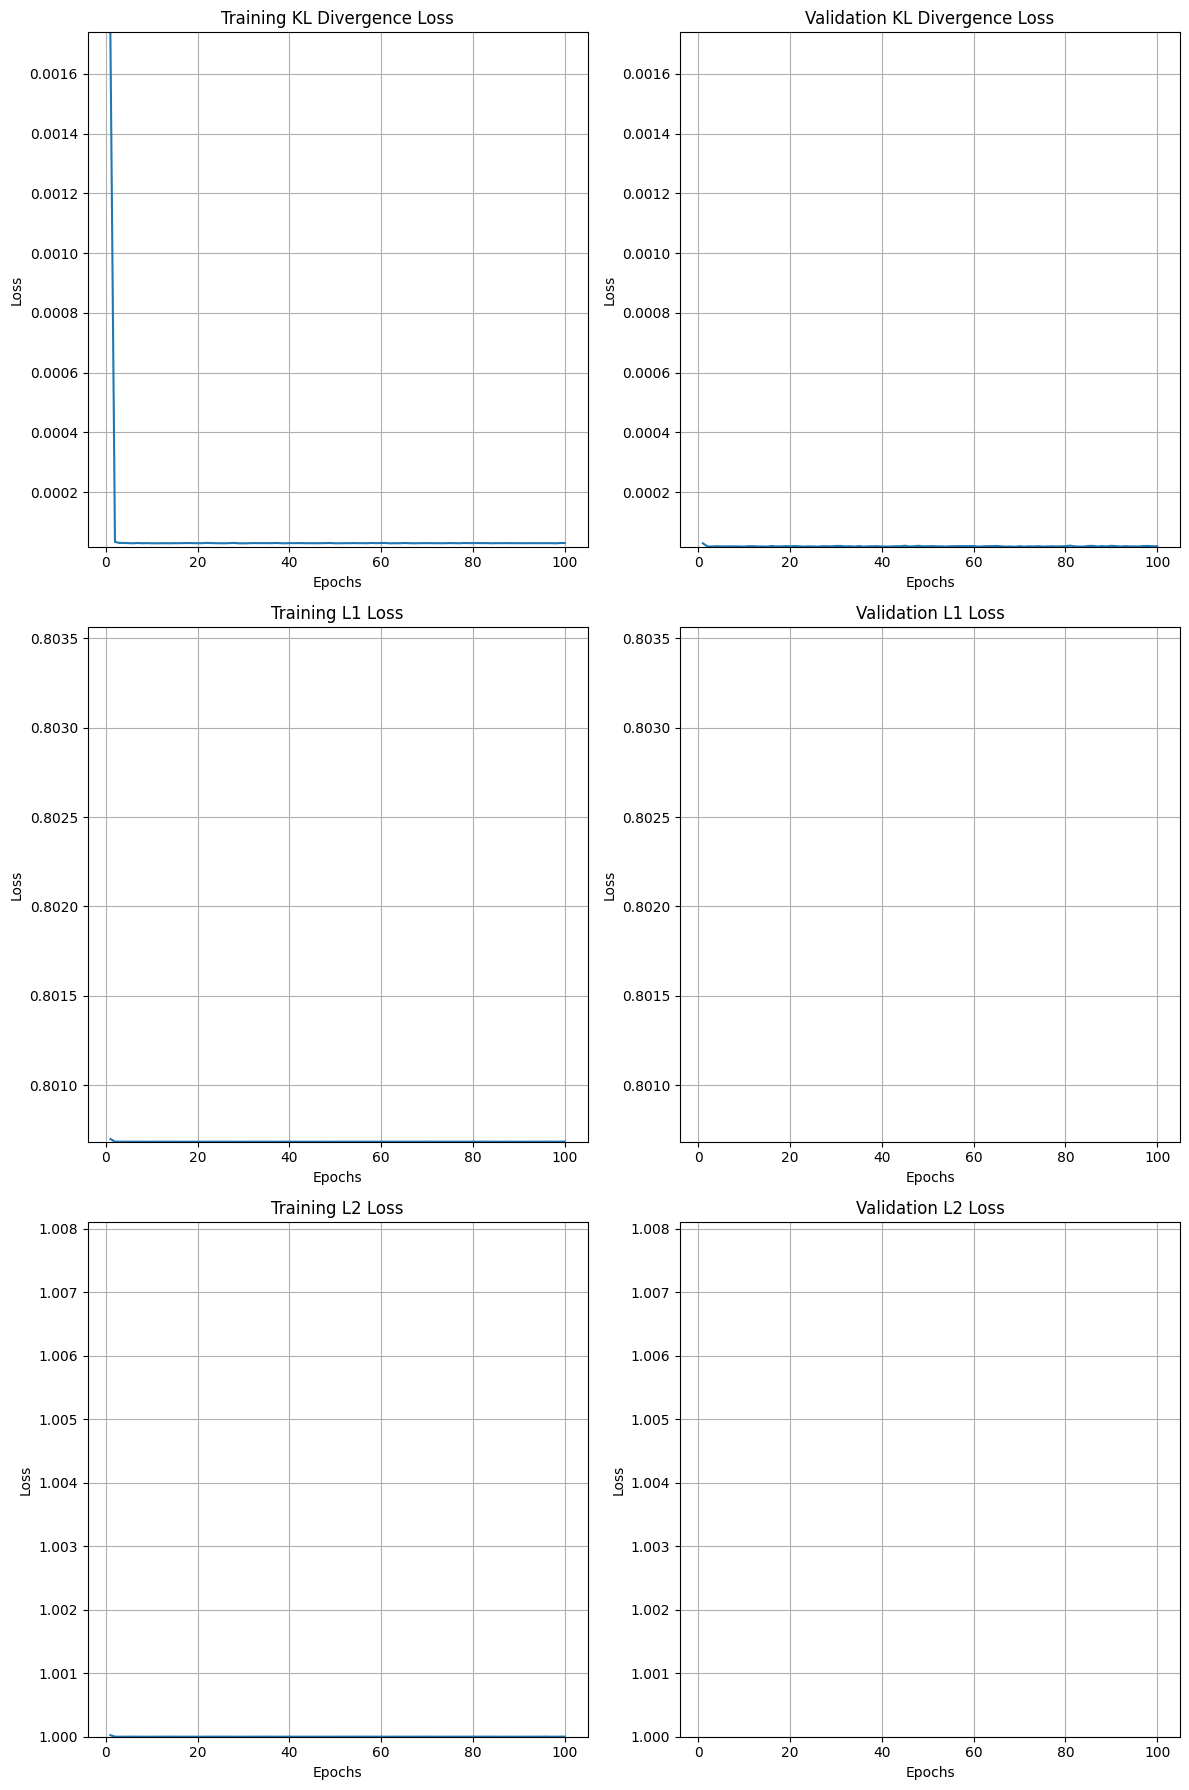

In [13]:
# * * * * * * * * * * * * * * * *
# Plot Losses
# * * * * * * * * * * * * * * * *
PlotLosses(losses, EPOCHS, model_dir)
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

In [14]:
# * * * * * * * * * * * * * * * *
# Best Validation Loss
# * * * * * * * * * * * * * * * *
PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

Best Validation Loss in Kelvins:
78.3137 K


In [15]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]


z0: 0.0002
z1: 0.0002
z2: 0.0004
z3: -0.0000


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 710.52it/s]


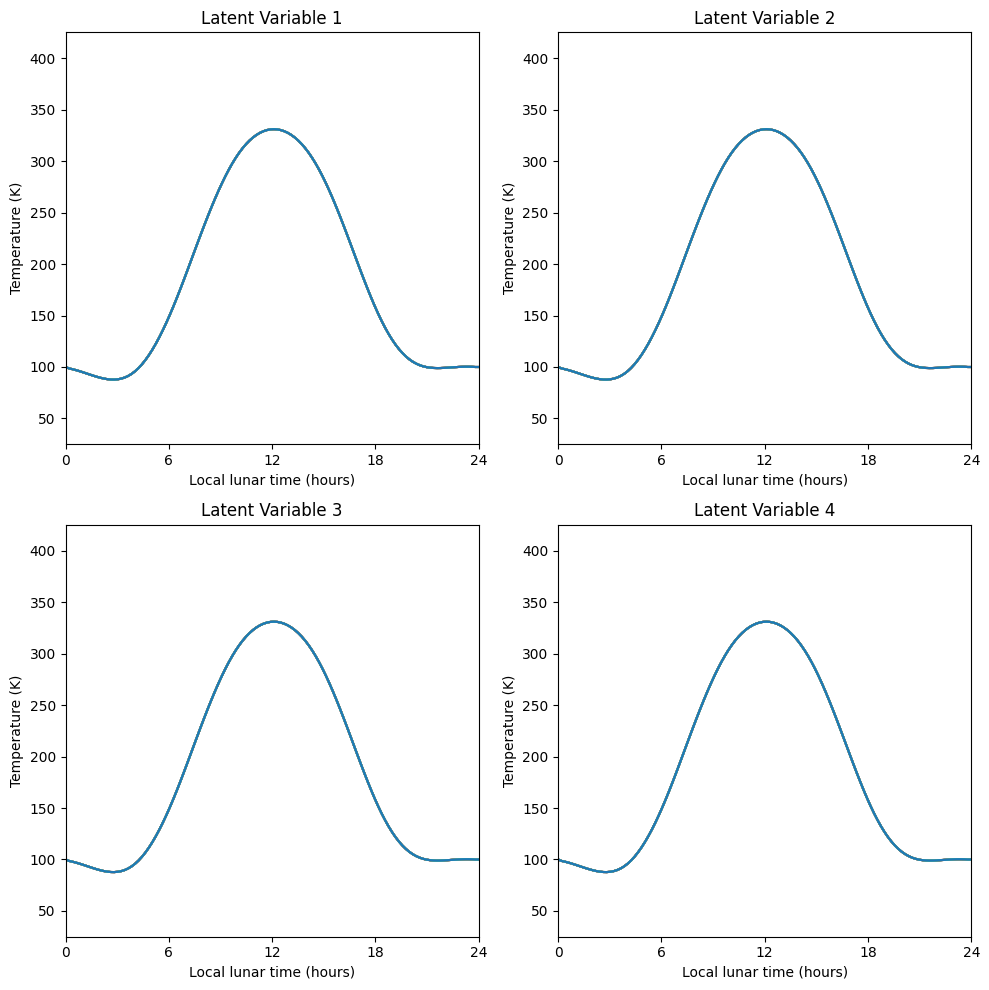

In [16]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)